In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.models import clone_model

In [2]:
data_dir = Path("./captcha_images_v2/")
data_dir2 = Path("./dataset/")


d1_epochs = 50 #Changed from 100 to 10
d2_epochs = 25 #Changed from 100 to 10

In [3]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [4]:
class DataSetHandler():
    def __init__(self,  data_dir,  img_size = (200, 50)):
        pass
        
    def init_calculations(self):
        pass
        
    def print_basics(self):
        pass
    
    # def split_data(images, labels, train_size=0.9, shuffle=True):
    def split_data(self, train_size=0.9, shuffle=True):
        pass

    def encode_single_sample(self, img_path, label):
        pass

    def process_dataset(self, invert_color = False):
        pass

    def plot_examples(self):
        pass
        
    def build_model(self):
        pass
    
    def train_model(self, epochs = 10, early_stopping_patience = 10):
        pass
        
    def make_predictions(self):
        pass


In [5]:
def init(self, data_dir,  img_size = (200, 50)):
    self.img_width = img_size[0]
    self.img_height = img_size[1]
    self.data_dir = data_dir;
    
    self.invert_color = False
    self.batch_size = 16
    self.downsample_factor = 4
    self.init_calculations()

# explain yada yada
def init_calculations(self):
    
    self.images = sorted(list(map(str, list(self.data_dir.glob("*.png")))))
    self.labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in self.images]
    
    self.max_length = max([len(label) for label in self.labels])
    
    characters = set(char for label in self.labels for char in label)
    self.characters = sorted(list(characters))

    self.char_to_num = layers.StringLookup(
        vocabulary=list(self.characters), mask_token=None
    )
        
    # Mapping integers back to original characters
    self.num_to_char = layers.StringLookup(
        vocabulary=self.char_to_num.get_vocabulary(), mask_token=None, invert=True
    )

DataSetHandler.__init__ = init
DataSetHandler.init_calculations = init_calculations

data1 = DataSetHandler(data_dir = data_dir)

In [6]:

# explain
def print_basics(self):
    print("Number of images found: ", len(self.images))
    print("Number of labels found: ", len(self.labels))
    print("Number of unique characters: ", len(self.characters))
    print("Characters present: ", self.characters)    
    
DataSetHandler.print_basics = print_basics

data1.print_basics()

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


## Splitting data

In [7]:
def split_data(self, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    images = np.array(self.images)
    labels = np.array(self.labels)
    size = len(self.images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    self.x_train, self.y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    self.x_valid, self.y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return self.x_train, self.x_valid, self.y_train, self.y_valid

DataSetHandler.split_data = split_data

data1.split_data();

## Data preprocessing

In [8]:
def encode_single_sample(self, img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [self.img_height, self.img_width])
    
    if (self.invert_color):
        # Inverting color
        img = 1- img
    
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = self.char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

DataSetHandler.encode_single_sample = encode_single_sample

In [9]:
def process_dataset(self, invert_color = False):
    self.invert_color = invert_color
    train_dataset = tf.data.Dataset.from_tensor_slices((self.x_train, self.y_train))
    self.train_dataset = (
        train_dataset.map(
            # self.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
            self.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(self.batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    validation_dataset = tf.data.Dataset.from_tensor_slices((self.x_valid, self.y_valid))
    self.validation_dataset = (
        validation_dataset.map(
            self.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(self.batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    return (self.train_dataset, self.validation_dataset)

DataSetHandler.process_dataset = process_dataset

data1.process_dataset();

## plotting examples

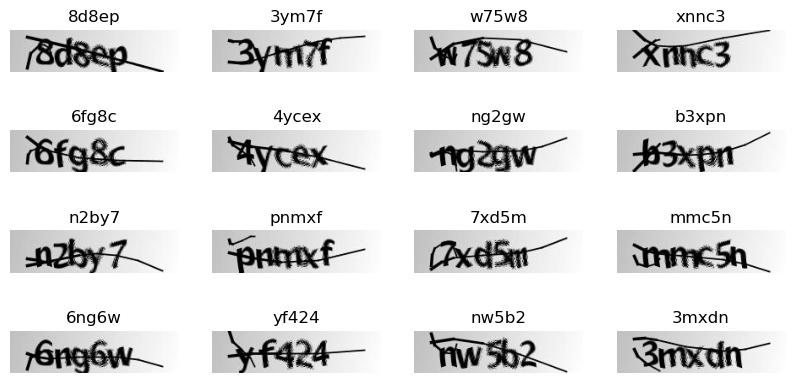

In [10]:
def plot_examples(self):
    _, ax = plt.subplots(4, 4, figsize=(10, 5))
    for batch in self.train_dataset.take(1):
        images = batch["image"]
        labels = batch["label"]
        for i in range(16):
            img = (images[i] * 255).numpy().astype("uint8")
            label = tf.strings.reduce_join(self.num_to_char(labels[i])).numpy().decode("utf-8")
            ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
            ax[i // 4, i % 4].set_title(label)
            ax[i // 4, i % 4].axis("off")
    plt.show()
    
DataSetHandler.plot_examples = plot_examples

data1.plot_examples()

## First model

In [11]:
def first_model(self):
    # Inputs to the model
    input_img = layers.Input(
        shape=(self.img_width, self.img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((self.img_width // 4), (self.img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(self.char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    self.model = model
    return model

In [12]:
data1.build_model = first_model

In [13]:
model1 = data1.build_model(data1);
model1.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

## training model

In [14]:
def train_model(self, epochs = 10, early_stopping_patience = 10, model = None):
    
    # Add early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
    )

    if (model):
        model_to_fit = model
    else: 
        model_to_fit = self.model    
    
    # Train the model
    self.history = model_to_fit.fit(
        self.train_dataset,
        validation_data=self.validation_dataset,
        epochs=epochs,
        callbacks=[early_stopping],
    )

DataSetHandler.train_model = train_model

data1.train_model(epochs = d1_epochs)

Epoch 1/50
59/59 [==============================] - 14s 127ms/step - loss: 20.4913 - val_loss: 16.2418
Epoch 2/50
59/59 [==============================] - 6s 98ms/step - loss: 16.3680 - val_loss: 16.2469
Epoch 3/50
59/59 [==============================] - 6s 97ms/step - loss: 16.3541 - val_loss: 16.2493
Epoch 4/50
59/59 [==============================] - 6s 101ms/step - loss: 16.3501 - val_loss: 16.2613
Epoch 5/50
59/59 [==============================] - 6s 100ms/step - loss: 16.3425 - val_loss: 16.2323
Epoch 6/50
59/59 [==============================] - 6s 97ms/step - loss: 16.3307 - val_loss: 16.2058
Epoch 7/50
59/59 [==============================] - 6s 100ms/step - loss: 16.3130 - val_loss: 16.2257
Epoch 8/50
59/59 [==============================] - 6s 97ms/step - loss: 16.2840 - val_loss: 16.1264
Epoch 9/50
59/59 [==============================] - 6s 98ms/step - loss: 16.1985 - val_loss: 16.0027
Epoch 10/50
59/59 [==============================] - 6s 99ms/step - loss: 16.1402 - va

Plotting the losses

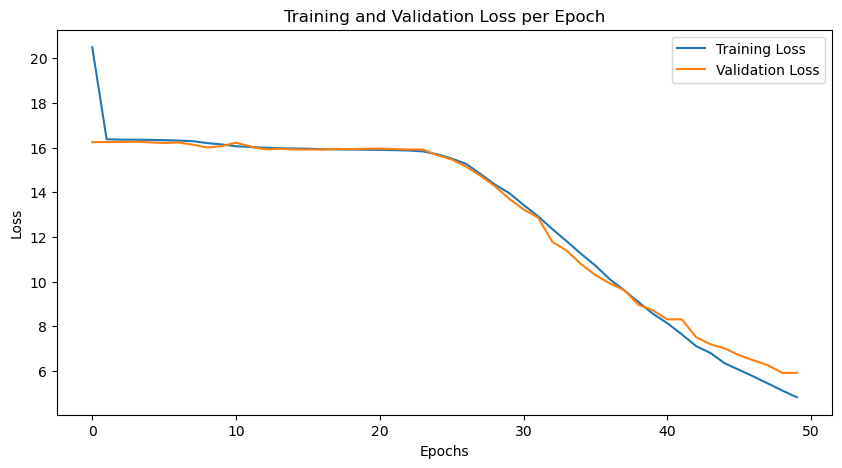

In [15]:
def plot_training_validation_loss(data_handler_instance):
    # Access the training and validation loss from the 'history' attribute
    train_losses = data_handler_instance.history.history['loss']
    val_losses = data_handler_instance.history.history['val_loss']

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Example usage
plot_training_validation_loss(data1)

## Making predictions

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

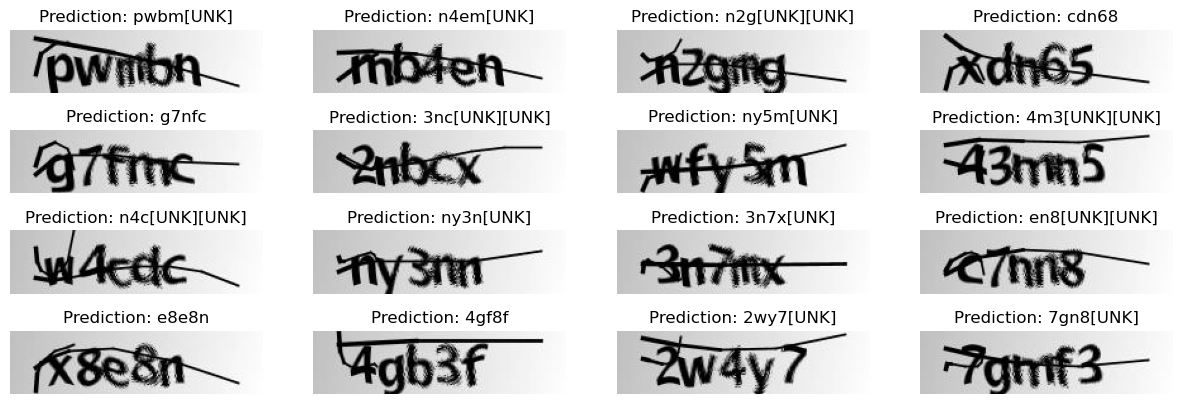

In [16]:
def make_predictions(self, model = None):
    
    if (model == None):
        _model = self.model
    else: 
        _model = model;
    # Get the prediction model by extracting layers till the output layer
    prediction_model = keras.models.Model(
        _model.get_layer(name="image").input, _model.get_layer(name="dense2").output
    )
    prediction_model.summary()

    # A utility function to decode the output of the network
    def decode_batch_predictions(pred):
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        # Use greedy search. For complex tasks, you can use beam search
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
            :, :self.max_length
        ]
        # Iterate over the results and get back the text
        output_text = []
        for res in results:
            res = tf.strings.reduce_join(self.num_to_char(res)).numpy().decode("utf-8")
            output_text.append(res)
        return output_text


    #  Let's check results on some validation samples
    for batch in self.validation_dataset.take(1):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        orig_texts = []
        for label in batch_labels:
            label = tf.strings.reduce_join(self.num_to_char(label)).numpy().decode("utf-8")
            orig_texts.append(label)

        _, ax = plt.subplots(4, 4, figsize=(15, 5))
        for i in range(len(pred_texts)):
            img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
            img = img.T
            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
    plt.show()
    
DataSetHandler.make_predictions = make_predictions

data1.make_predictions()

In [17]:
def evaluate_accuracy_on_dataset(self):
    correct_predictions = 0
    total_predictions = 0

    # Ensure the prediction model is constructed
    if not hasattr(self, 'prediction_model'):
        self.prediction_model = keras.models.Model(
            self.model.get_layer(name="image").input, self.model.get_layer(name="dense2").output
        )

    # A utility function to decode the output of the network
    def decode_batch_predictions(pred):
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :self.max_length]
        output_text = []
        for res in results:
            res = tf.strings.reduce_join(self.num_to_char(res)).numpy().decode("utf-8")
            output_text.append(res)
        return output_text

    # Iterate over the entire validation dataset
    for batch in self.validation_dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        # Predict and decode using the prediction model
        preds = self.prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        # Compare predictions with actual labels
        for i in range(len(pred_texts)):
            pred = pred_texts[i]
            truth = tf.strings.reduce_join(self.num_to_char(batch_labels[i])).numpy().decode("utf-8")
            if pred == truth:
                correct_predictions += 1
            total_predictions += 1

    # Calculate and return the accuracy
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy

DataSetHandler.evaluate_accuracy_on_dataset = evaluate_accuracy_on_dataset

# Example usage
accuracy = data1.evaluate_accuracy_on_dataset()
print(f"Accuracy: {accuracy:.4f}")

1/1 [==============================] - 0s 30ms/step
Accuracy: 0.0385


Predict entire validation set, instead of a single batch:

In [18]:
def evaluate_model_on_validation(self):
    # Reconstruct the prediction model if not already available
    if not hasattr(self, 'prediction_model'):
        self.prediction_model = keras.models.Model(
            self.model.get_layer(name="image").input, self.model.get_layer(name="dense2").output
        )

    # Function to decode predictions
    def decode_predictions(pred):
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :self.max_length]
        output_text = []
        for res in results:
            res = tf.strings.reduce_join(self.num_to_char(res)).numpy().decode("utf-8")
            output_text.append(res)
        return output_text

    # Initialize counters
    total_characters = 0
    correct_predictions = 0

    # Iterate over the entire validation dataset
    for batch in self.validation_dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        # Predict and decode
        preds = self.prediction_model.predict(batch_images)
        pred_texts = decode_predictions(preds)

        # Compare predictions with actual labels
        for i in range(len(pred_texts)):
            pred = pred_texts[i]
            truth = tf.strings.reduce_join(self.num_to_char(batch_labels[i])).numpy().decode("utf-8")

            # Update counters
            total_characters += len(truth)
            correct_predictions += sum(p == t for p, t in zip(pred, truth))

    # Calculate character-level accuracy
    character_accuracy = correct_predictions / total_characters
    print(f"Character-level accuracy: {character_accuracy:.4f}")

DataSetHandler.evaluate_model_on_validation = evaluate_model_on_validation

# Example usage
data1.evaluate_model_on_validation()

1/1 [==============================] - 0s 32ms/step
Character-level accuracy: 0.3865


In [19]:
#import seaborn as sns
import pandas as pd

More advanced Accuracy model:

1/1 [==============================] - 0s 30ms/step


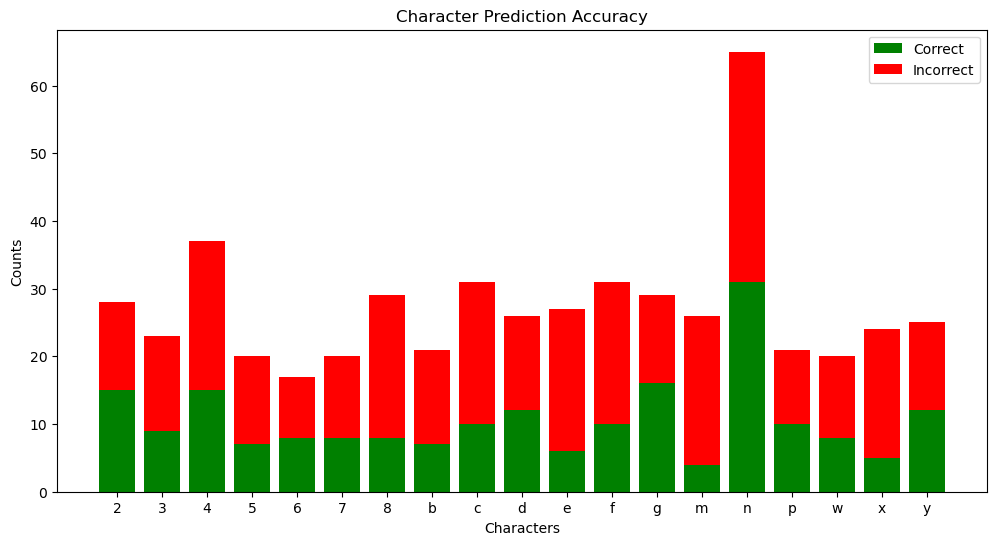

Character  Correct  Incorrect
        2       15         13
        3        9         14
        4       15         22
        5        7         13
        6        8          9
        7        8         12
        8        8         21
        b        7         14
        c       10         21
        d       12         14
        e        6         21
        f       10         21
        g       16         13
        m        4         22
        n       31         34
        p       10         11
        w        8         12
        x        5         19
        y       12         13


In [20]:
def evaluate_character_accuracy(self):
    # Initialize dictionaries to track correct and incorrect predictions
    correct_predictions = {char: 0 for char in self.characters}
    incorrect_predictions = {char: 0 for char in self.characters}

    # Reconstruct the prediction model if not already available
    if not hasattr(self, 'prediction_model'):
        self.prediction_model = keras.models.Model(
            self.model.get_layer(name="image").input, self.model.get_layer(name="dense2").output
        )

    # Function to decode predictions
    def decode_predictions(pred):
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :self.max_length]
        output_text = []
        for res in results:
            res = tf.strings.reduce_join(self.num_to_char(res)).numpy().decode("utf-8")
            output_text.append(res)
        return output_text

    # Iterate over the entire validation dataset
    for batch in self.validation_dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        # Predict and decode
        preds = self.prediction_model.predict(batch_images)
        pred_texts = decode_predictions(preds)

        # Compare predictions with actual labels and update counts
        for pred_text, label in zip(pred_texts, batch_labels):
            label_text = tf.strings.reduce_join(self.num_to_char(label)).numpy().decode("utf-8")
            for pred_char, true_char in zip(pred_text, label_text):
                if pred_char == true_char:
                    correct_predictions[pred_char] += 1
                else:
                    incorrect_predictions[true_char] += 1

    # Create a DataFrame from the summary data
    data = {
        "Character": list(self.characters),
        "Correct": [correct_predictions[char] for char in self.characters],
        "Incorrect": [incorrect_predictions[char] for char in self.characters]
    }
    df = pd.DataFrame(data)

    # Plotting the bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(df["Character"], df["Correct"], color='green', label='Correct')
    plt.bar(df["Character"], df["Incorrect"], bottom=df["Correct"], color='red', label='Incorrect')
    plt.ylabel('Counts')
    plt.xlabel('Characters')
    plt.title('Character Prediction Accuracy')
    plt.legend()
    plt.show()

    return df

DataSetHandler.evaluate_character_accuracy = evaluate_character_accuracy

# Example usage
accuracy_df = data1.evaluate_character_accuracy()
print(accuracy_df.to_string(index=False))

1/1 [==============================] - 0s 30ms/step


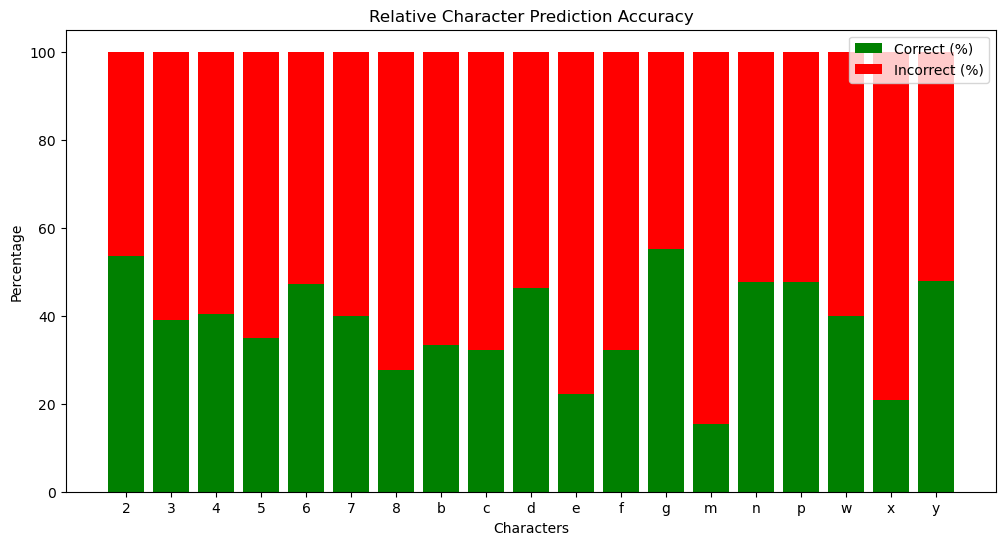

Character  Correct (%)  Incorrect (%)
        2         53.6           46.4
        3         39.1           60.9
        4         40.5           59.5
        5         35.0           65.0
        6         47.1           52.9
        7         40.0           60.0
        8         27.6           72.4
        b         33.3           66.7
        c         32.3           67.7
        d         46.2           53.8
        e         22.2           77.8
        f         32.3           67.7
        g         55.2           44.8
        m         15.4           84.6
        n         47.7           52.3
        p         47.6           52.4
        w         40.0           60.0
        x         20.8           79.2
        y         48.0           52.0


In [21]:
def evaluate_character_accuracy_relative(self):
    # Initialize dictionaries to track correct and incorrect predictions
    correct_predictions = {char: 0 for char in self.characters}
    total_predictions = {char: 0 for char in self.characters}

    # Reconstruct the prediction model if not already available
    if not hasattr(self, 'prediction_model'):
        self.prediction_model = keras.models.Model(
            self.model.get_layer(name="image").input, self.model.get_layer(name="dense2").output
        )

    # Function to decode predictions
    def decode_predictions(pred):
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :self.max_length]
        output_text = []
        for res in results:
            res = tf.strings.reduce_join(self.num_to_char(res)).numpy().decode("utf-8")
            output_text.append(res)
        return output_text

    # Iterate over the entire validation dataset
    for batch in self.validation_dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        # Predict and decode
        preds = self.prediction_model.predict(batch_images)
        pred_texts = decode_predictions(preds)

        # Compare predictions with actual labels and update counts
        for pred_text, label in zip(pred_texts, batch_labels):
            label_text = tf.strings.reduce_join(self.num_to_char(label)).numpy().decode("utf-8")
            for pred_char, true_char in zip(pred_text, label_text):
                total_predictions[true_char] += 1
                if pred_char == true_char:
                    correct_predictions[pred_char] += 1

    # Calculate the percentage of correct predictions
    data = {
        "Character": self.characters,
        "Correct (%)": [(correct_predictions[char] / total_predictions[char] * 100) if total_predictions[char] > 0 else 0 for char in self.characters],
        "Incorrect (%)": [(100 - (correct_predictions[char] / total_predictions[char] * 100)) if total_predictions[char] > 0 else 0 for char in self.characters]
    }
    df = pd.DataFrame(data)
    
    # Round the values to 2 decimal places
    df = df.round(1)

    # Plotting the bar chart for relative accuracy
    plt.figure(figsize=(12, 6))
    plt.bar(df["Character"], df["Correct (%)"], color='green', label='Correct (%)')
    plt.bar(df["Character"], df["Incorrect (%)"], bottom=df["Correct (%)"], color='red', label='Incorrect (%)')
    plt.ylabel('Percentage')
    plt.xlabel('Characters')
    plt.title('Relative Character Prediction Accuracy')
    plt.legend()
    plt.show()

    return df

DataSetHandler.evaluate_character_accuracy_relative = evaluate_character_accuracy_relative

# Example usage
relative_accuracy_df = data1.evaluate_character_accuracy_relative()
print(relative_accuracy_df.to_string(index=False))

# **Second dataset**

## Defining the second model

In [ ]:
def second_model(self, base_model = None):
    # Inputs to the model
    input_img = layers.Input(
        shape=(self.img_width, self.img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
    if (base_model):
        
        base_model = keras.models.clone_model(base_model)
        base_model.trainable = False
        base_model.summary()
        inputs = base_model(input_img, training = False)
    else: 
        inputs = input_img
        
        
    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(inputs)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((self.img_width // 4), (self.img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(self.char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    self.model = model
    return model

## process data and show example

In [ ]:
data2 = DataSetHandler(data_dir2)
data2.split_data();
data2.process_dataset(invert_color = True);
data2.plot_examples()

##  build second model

In [ ]:




data2.build_model = second_model
model2 = data2.build_model(data2);
model2.summary()

In [ ]:
data2.train_model(epochs = d2_epochs)

In [ ]:
data2.make_predictions()

In [ ]:
data2.evaluate_model_on_validation()

In [ ]:
plot_training_validation_loss(data2)

In [ ]:
accuracy_df = data2.evaluate_character_accuracy()
print(accuracy_df.to_string(index=False))

In [ ]:
relative_accuracy_df = data2.evaluate_character_accuracy_relative()
print(relative_accuracy_df.to_string(index=False))

In [ ]:
data2.make_predictions(model = data1.model)

## Train on top of model 1  

In [ ]:
# transfered_model = second_model(data2, base_model = data1.model)

In [ ]:
# data2.train_model(epochs = d2_epochs, model = transfered_model)

In [ ]:
# data2.make_predictions(model = transfered_model)